In [1]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

In [2]:
class MonotonicLinear(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size  = input_size
    self.output_size = output_size
    self.weights = torch.nn.Parameter(torch.rand((output_size, input_size), dtype=torch.float32))

  def forward(self, x):
    z = torch.mm(x, torch.exp(self.weights.t()))
    return z

In [3]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input11 = MonotonicLinear(1, 4)
    self.input12 = torch.nn.Linear(2, 4)
    self.max1    = torch.nn.MaxPool1d(4)

    self.input21 = MonotonicLinear(1, 4)
    self.input22 = torch.nn.Linear(2, 4)
    self.max2    = torch.nn.MaxPool1d(4)

    self.output = torch.nn.MaxPool1d(2)

  def forward(self, x_m, x_u):
    z1 = torch.add(self.input11(x_m), self.input12(x_u))
    z1 = self.max1(z1)

    z2 = torch.add(self.input21(x_m), self.input22(x_u))
    z2 = self.max1(z2)

    z = torch.concat((z1,z2), axis=1)
    z = self.output(-z)

    return -z

# Create network
device = torch.device("cpu")
net = Net().to(device)

In [4]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x_m_data, testset.x_u_data)
    
    # R^2
    SSR = torch.sum(torch.square(pred_Y - testset.y_data))
    SST = torch.sum(torch.square(pred_Y - torch.mean(testset.y_data)))
    r2 = 1 - SSR/SST

    # RMSE
    rmse = torch.sqrt(torch.mean(torch.square(pred_Y - testset.y_data)))
    return r2, rmse

In [5]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [6]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
    Tz_k   = np.array(df['room_temp']).reshape(-1,1)[start: end]
    msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]

    tmp_x_u = np.concatenate((Tz_k, msa_k1), axis=1)
    tmp_y   = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]

    self.x_m_data = torch.tensor(Tsa_k1, dtype=torch.float32)
    self.x_u_data = torch.tensor(tmp_x_u, dtype=torch.float32)
    self.y_data   = torch.tensor(tmp_y, dtype=torch.float32)

  def __len__(self):
    return len(self.y_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp_m  = self.x_m_data[idx]
    inp_u  = self.x_u_data[idx]
    outp   = self.y_data[idx]
    sample = {'inp_m':inp_m, 'inp_u':inp_u, 'outp':outp}
    return sample

# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv'
n_train  = 32
train_ds = Data(src_file, start=0,       end=n_train)
test_ds  = Data(src_file, start=n_train, end=1600)

In [7]:
# train model
max_epochs = 120000
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.002)

R2_train   = np.array([])
RMSE_train = np.array([])
R2_test    = np.array([])
RMSE_test  = np.array([])

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X_m = batch['inp_m']
        X_u = batch['inp_u']
        Y   = batch['outp']

        optimizer.zero_grad()
        output = net(X_m, X_u)             # compute the output of the Network
        loss_val = loss_func(output, Y) + 0.01*loss_func(output, X_u[:,0].reshape(-1,1))   # loss function
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1

    net.eval()
    R2_train   = np.append(R2_train, eval(net, train_ds)[0].item())
    RMSE_train = np.append(RMSE_train, eval(net, train_ds)[1].item())
    R2_test    = np.append(R2_test, eval(net, test_ds)[0].item())
    RMSE_test  = np.append(RMSE_test, eval(net, test_ds)[1].item())


    if(epoch%1000==0):
        print("epoch = %5d \t loss = %11.3f \t RMSE = %8.3f \t R2 = %8.5f" % (epoch, loss/count, eval(net, test_ds)[1].item(), eval(net, test_ds)[0].item()))

epoch =     0 	 loss =    4987.432 	 RMSE =   78.192 	 R2 =  0.00335
epoch =  1000 	 loss =      13.459 	 RMSE =   18.360 	 R2 = -0.14448
epoch =  2000 	 loss =       6.887 	 RMSE =   18.212 	 R2 = -0.14856
epoch =  3000 	 loss =       4.508 	 RMSE =   17.613 	 R2 = -0.15515
epoch =  4000 	 loss =       3.431 	 RMSE =   17.745 	 R2 = -0.15420
epoch =  5000 	 loss =       3.125 	 RMSE =   16.564 	 R2 = -0.16639
epoch =  6000 	 loss =       2.793 	 RMSE =   15.343 	 R2 = -0.18060
epoch =  7000 	 loss =       2.372 	 RMSE =   13.786 	 R2 = -0.20251
epoch =  8000 	 loss =       1.893 	 RMSE =   11.963 	 R2 = -0.23587
epoch =  9000 	 loss =       1.412 	 RMSE =   10.034 	 R2 = -0.28528
epoch = 10000 	 loss =       0.996 	 RMSE =    8.429 	 R2 = -0.34513
epoch = 11000 	 loss =       0.671 	 RMSE =    7.064 	 R2 = -0.41896
epoch = 12000 	 loss =       0.441 	 RMSE =    5.933 	 R2 = -0.50643
epoch = 13000 	 loss =       0.289 	 RMSE =    5.060 	 R2 = -0.59890
epoch = 14000 	 loss =       0.200

In [8]:
def plot(dataset, size):
  with torch.no_grad():
      pred_Y = net(dataset.x_m_data, dataset.x_u_data)

  plt.figure(figsize=size)
  plt.plot(dataset.y_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

RMSE: 0.059809017926454544
R2:   0.9674637913703918


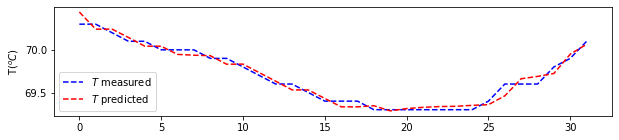

In [9]:
net.eval()
print("RMSE:", eval(net, train_ds)[1].item())
print("R2:  ", eval(net, train_ds)[0].item())
plot(train_ds, (10, 2))

RMSE: 0.14739485085010529
R2:   0.9941712021827698


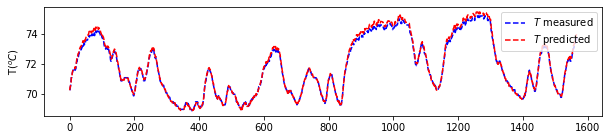

In [10]:
net.eval()
print("RMSE:", eval(net, test_ds)[1].item())
print("R2:  ",   eval(net, test_ds)[0].item())
plot(test_ds, (10, 2))

In [11]:
print(np.argmax(R2_test))
print(np.max(R2_test))

62748
0.9978976249694824
